<img src="../images/logos/wradlib_logo.svg.png" width=250 alt="wradlib logo png"></img>

# wradlib radar data io, visualisation, gridding and gis export

---

## Overview

Within this notebook, we will cover:

1. Reading radar volume data into xarray based RadarVolume
1. Examination of RadarVolume and Sweeps
1. Plotting of sweeps, simple and mapmaking
1. Gridding and GIS output

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Xarray Basics](https://tutorial.xarray.dev/intro.html) | Helpful | Basic Dataset/DataArray |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Helpful | Basic Plotting |
| [Cartopy Basics](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | Projections |
| [GDAL Basiscs](https://gdal.org/api/python_bindings.html) | Helpful | Raster |

- **Time to learn**: 15 minutes

---

## Imports

In [1]:
import glob
import pathlib

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib import ticker as tick
from osgeo import gdal

import wradlib as wrl
import xradar as xd

## Import data into RadarVolume

We have this special case here with Rainbow data where moments are splitted across files. Each file nevertheless consists of all sweeps comprising the volume. We'll use some special nested ordering to read the files.

In [2]:
fglob = "data/rainbow/meteoswiss/*.vol"

In [3]:
vol = wrl.io.open_rainbow_mfdataset(fglob, combine="by_coords", concat_dim=None)

/home/jgiles/mambaforge/envs/wradlib4/lib/python3.11/site-packages/wradlib/io/rainbow.py:222: FutureWarning: `open_rainbow_mfdataset` is deprecated and will be removed in 2.0. Future development will take place in `xradar`-package.
  return open_radar_mfdataset(


  0%|          | 0/10 [00:00<?, ?it/s]

Note that we get a warning because this method of loading data will be deprecated in the future in favor of the xradar package. More on alternative loading methods below.

### Examine RadarVolume

The RadarVolume is a shallow class which tries to comply to CfRadial2/WMO-FM301, see [WMO-CF_Extensions](https://community.wmo.int/activity-areas/wis/wmo-cf-extensions).

The printout of `RadarVolume` just lists the dimensions and the associated elevations.

In [4]:
display(vol)

<wradlib.RadarVolume>
Dimension(s): (sweep: 10)
Elevation(s): (0.0, 1.3, 2.9, 4.9, 7.3, 10.2, 13.8, 18.2, 23.5, 30.0)

### Root Group

The root-group is essentially an overview over the volume, more or less aligned with CfRadial metadata.

In [5]:
vol.root

<xarray.Dataset>
Dimensions:              (sweep: 10)
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2019-10-21T08:24:09Z'
    time_coverage_end    <U20 '2019-10-21 08:29:34Z'
    latitude             float64 46.77
    longitude            float64 6.954
    altitude             float64 735.0
    sweep_group_name     (sweep) <U7 'sweep_0' 'sweep_1' ... 'sweep_8' 'sweep_9'
    sweep_fixed_angle    (sweep) float64 0.0 1.3 2.9 4.9 ... 13.8 18.2 23.5 30.0
Attributes:
    version:          None
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    fixed_angle:      0.0

### Sweep Groups

Sweeps are available in a sequence attached to the `RadarVolume` object.

In [6]:
swp = vol[0]
display(swp)

<xarray.Dataset>
Dimensions:            (azimuth: 360, range: 1400)
Coordinates:
  * azimuth            (azimuth) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * range              (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
    elevation          (azimuth) float64 dask.array<chunksize=(360,), meta=np.ndarray>
    rtime              (azimuth) datetime64[ns] dask.array<chunksize=(360,), meta=np.ndarray>
    sweep_mode         <U20 'azimuth_surveillance'
    longitude          float64 6.954
    latitude           float64 46.77
    altitude           float64 735.0
    time               datetime64[ns] 2019-10-21T08:24:09.041666500
Data variables:
    DBZH               (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    sweep_number       int64 0
    prt_mode           <U7 'not_set'
    follow_mode        <U7 'not_set'
    sweep_fixed_angle  float64 0.0
    KDP                (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    PHIDP              (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    RHOHV              (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    VRADH              (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    WRADH              (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    ZDR                (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
Attributes:
    fixed_angle:  0.0

## Inspect Scan Strategy

Considering volume files it's nice to have an overview over the scan strategy. We can choose some reasonable values for the layout.

In [7]:
# Number of azimuths (rays)
swp["azimuth"].count()

<xarray.DataArray 'azimuth' ()>
array(360)
Coordinates:
    sweep_mode  <U20 'azimuth_surveillance'
    longitude   float64 6.954
    latitude    float64 46.77
    altitude    float64 735.0
    time        datetime64[ns] 2019-10-21T08:24:09.041666500

In [8]:
# Number of range bins and resolution
swp["range"]

<xarray.DataArray 'range' (range: 1400)>
array([2.5000e+01, 7.5000e+01, 1.2500e+02, ..., 6.9875e+04, 6.9925e+04,
       6.9975e+04], dtype=float32)
Coordinates:
  * range       (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
    sweep_mode  <U20 'azimuth_surveillance'
    longitude   float64 6.954
    latitude    float64 46.77
    altitude    float64 735.0
    time        datetime64[ns] 2019-10-21T08:24:09.041666500
Attributes:
    units:                           meters
    standard_name:                   projection_range_coordinate
    long_name:                       range_to_measurement_volume
    axis:                            radial_range_coordinate
    meters_between_gates:            50.0
    spacing_is_constant:             true
    meters_to_center_of_first_gate:  25.0

In [9]:
# Elevations
vol.root.sweep_fixed_angle.values

array([ 0. ,  1.3,  2.9,  4.9,  7.3, 10.2, 13.8, 18.2, 23.5, 30. ])

In [10]:
nrays = 360
nbins = 1400
range_res = 50
ranges = np.arange(nbins) * range_res
elevs = vol.root.sweep_fixed_angle.values
sitecoords = (
    vol.root.longitude.values.item(),
    vol.root.latitude.values.item(),
    vol.root.altitude.values.item(),
)

beamwidth = 1.0 # this is unfortunately not in the volume, we need to know this from somewhere else

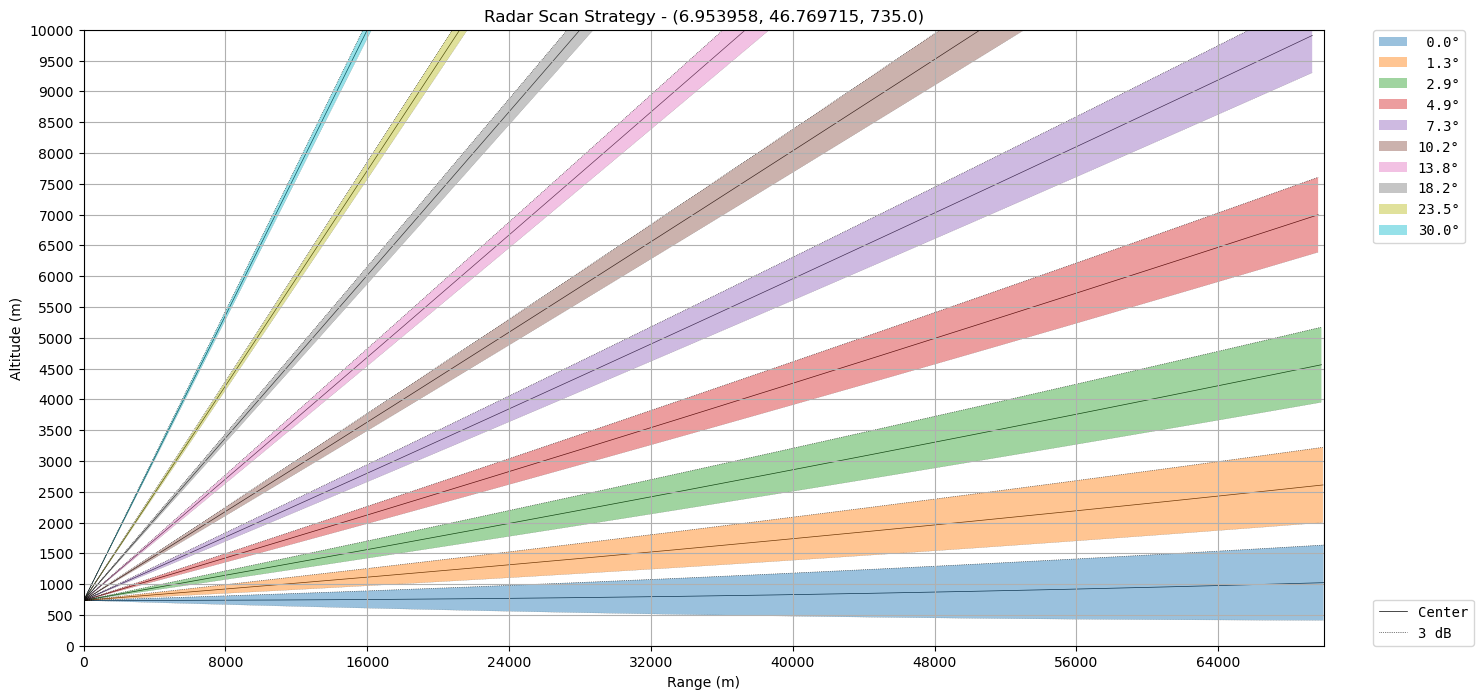

In [11]:
ax = wrl.vis.plot_scan_strategy(ranges, elevs, sitecoords)

We can plot it on top of the terrain derived from SRTM DEM.

In [12]:
import os

os.environ["WRADLIB_EARTHDATA_BEARER_TOKEN"] = ""
os.environ["WRADLIB_DATA"] = "data/wradlib-data"

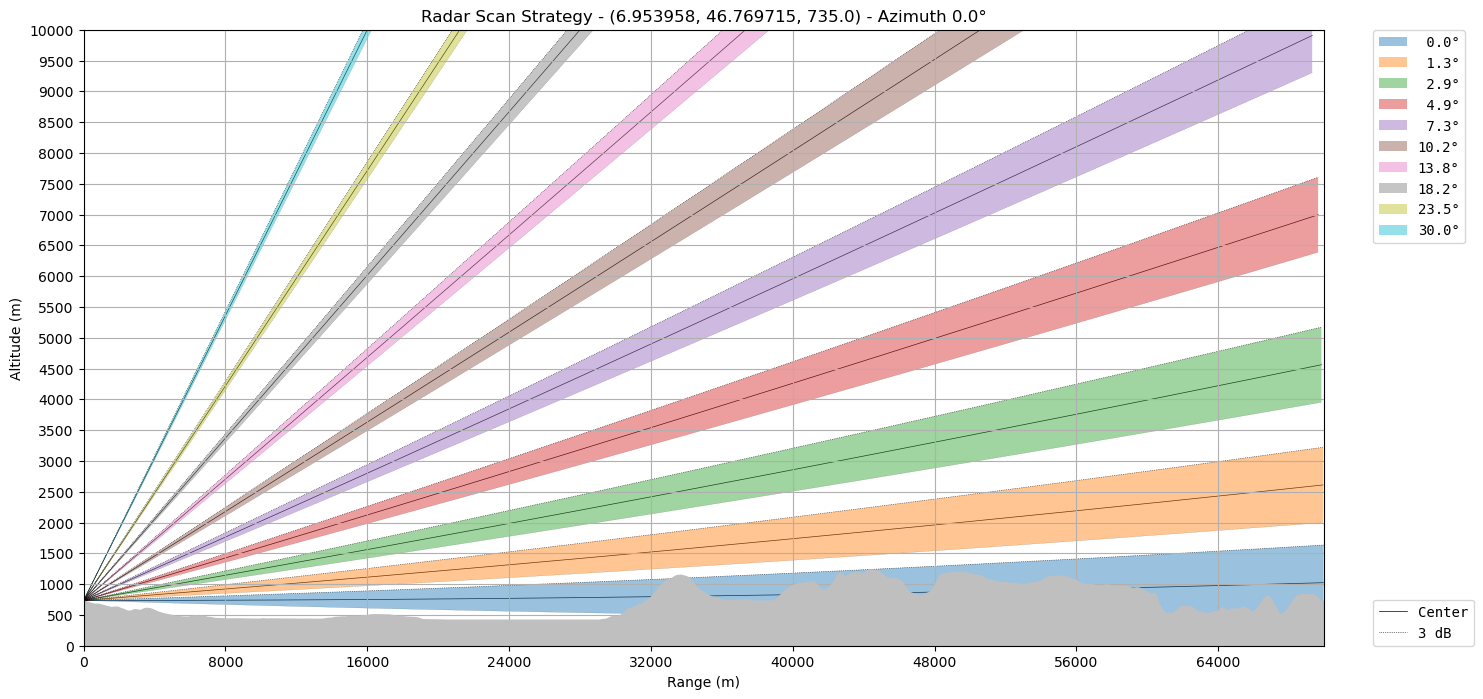

In [13]:
ax = wrl.vis.plot_scan_strategy(ranges, elevs, sitecoords, terrain=True)

Let's make the earth go round...

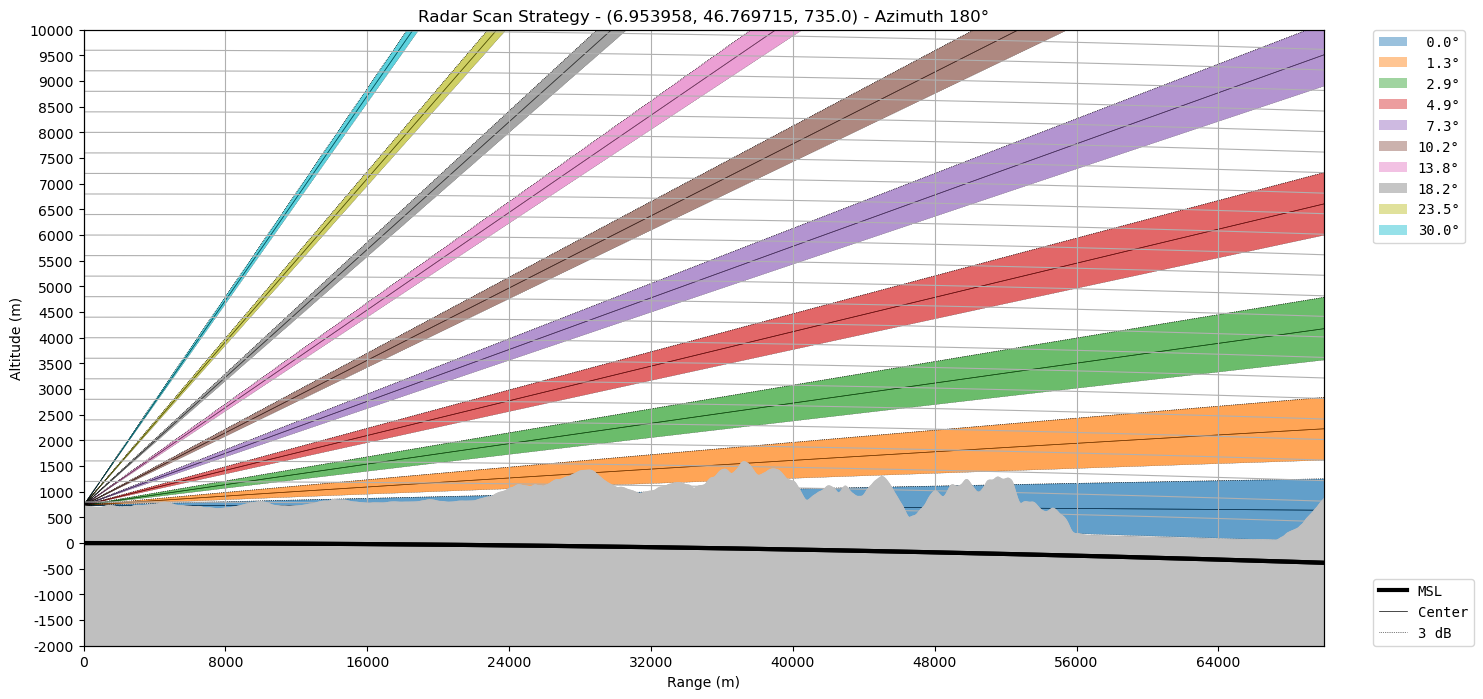

In [14]:
# "cg=True" plots in curvilinear grid and "az=180" plots the 180 degree azimuth
ax = wrl.vis.plot_scan_strategy(
    ranges, elevs, sitecoords, cg=True, terrain=True, az=180
)

## Plotting Radar Data
### Time vs. Azimuth

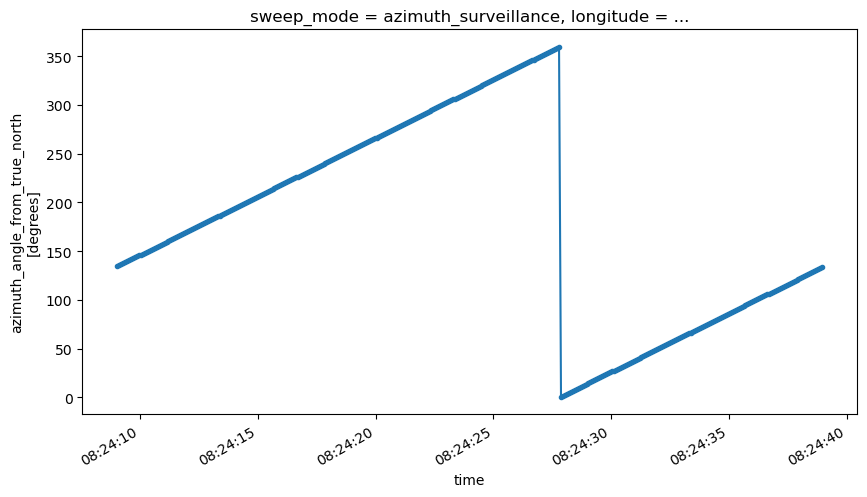

In [15]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(111)
swp.azimuth.sortby("rtime").plot(x="rtime", marker=".")

### Range vs. Azimuth/Time

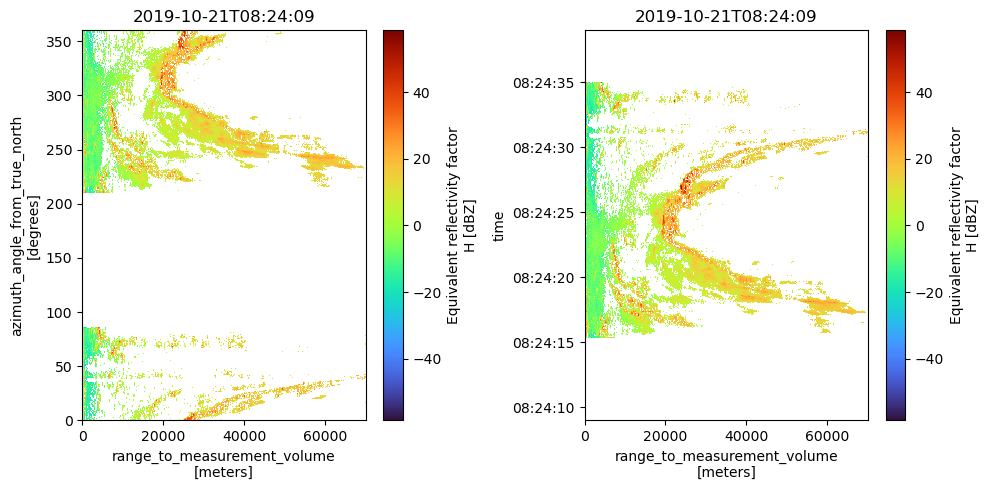

In [16]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
swp.DBZH.plot(cmap="turbo", ax=ax1)
ax1.set_title(f"{swp.time.values.astype('M8[s]')}")
ax2 = fig.add_subplot(122)
swp.DBZH.sortby("rtime").plot(y="rtime", cmap="turbo", ax=ax2)
ax2.set_title(f"{swp.time.values.astype('M8[s]')}")
plt.tight_layout()

### Georeferenced as Plan Position Indicator

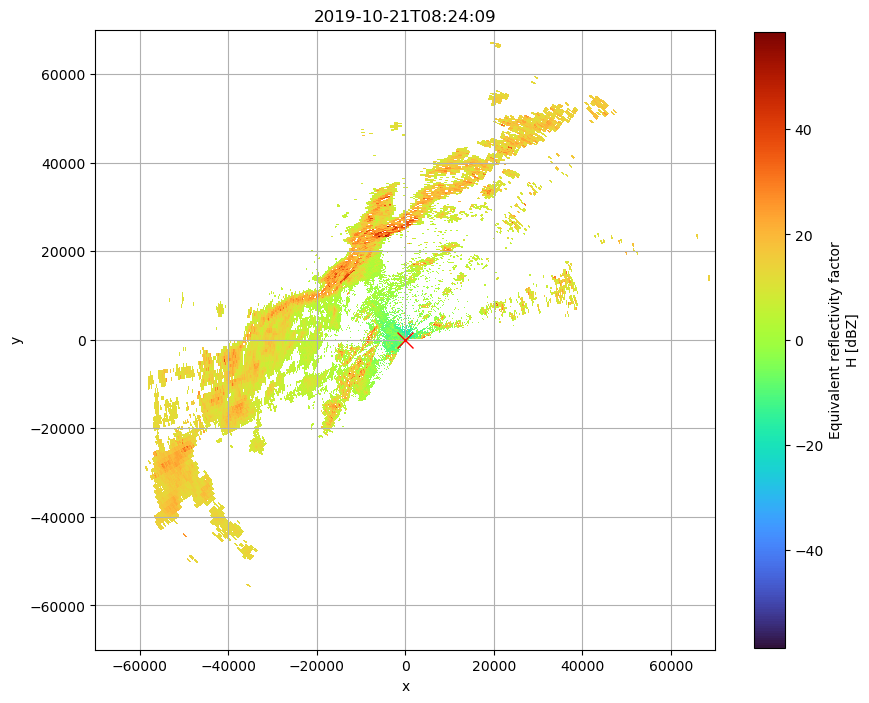

In [17]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
swp.DBZH.pipe(wrl.georef.georeference_dataset).plot(
    x="x", y="y", ax=ax1, cmap="turbo", cbar_kwargs=dict(shrink=0.8)
)
ax1.plot(0, 0, "rx", markersize=12)
ax1.set_title(f"{swp.time.values.astype('M8[s]')}")
ax1.grid()
ax1.set_aspect("equal")

### Basic MapMaking with cartopy

The data will be georeferenced as `Azimuthal Equidistant Projection` centered at the radar. For the map projection we will use `Mercator`.

In [18]:
map_trans = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values, central_longitude=swp.longitude.values
)
map_proj = ccrs.Mercator(central_longitude=swp.longitude.values)

In [19]:
def plot_borders(ax):
    borders = cfeature.NaturalEarthFeature(
        category="cultural", name="admin_0_countries", scale="10m", facecolor="none"
    )
    ax.add_feature(borders, edgecolor="black", lw=2, zorder=4)

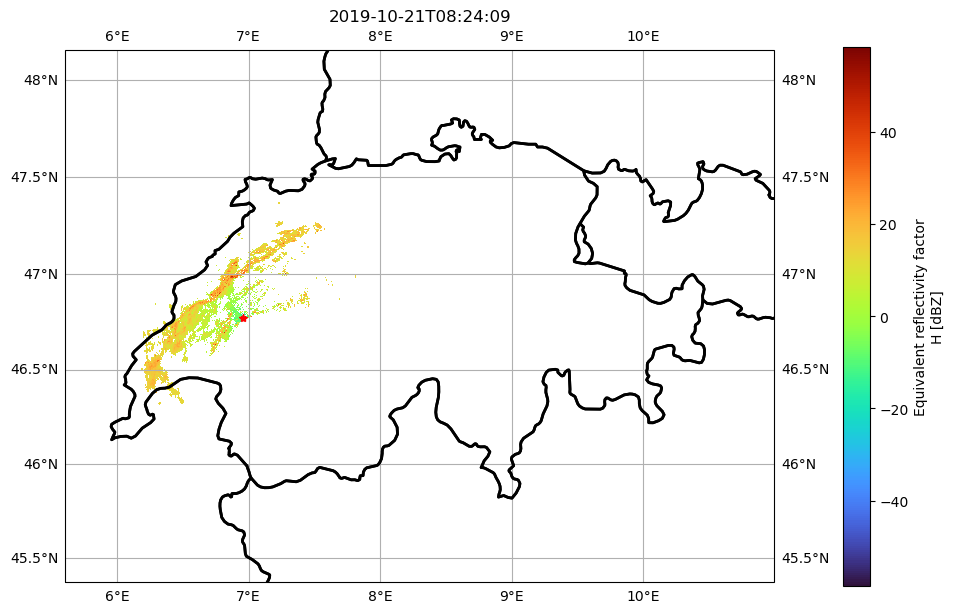

In [20]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=map_proj)
cbar_kwargs = dict(shrink=0.7, pad=0.075)
pm = swp.DBZH.pipe(wrl.georef.georeference_dataset).plot(
    ax=ax, x="x", y="y", cbar_kwargs=cbar_kwargs, cmap="turbo", transform=map_trans
)
plot_borders(ax)
ax.gridlines(draw_labels=True)
ax.plot(
    swp.longitude.values, swp.latitude.values, transform=map_trans, marker="*", c="r"
)
ax.set_title(f"{swp.time.values.astype('M8[s]')}")
ax.set_xlim(-15e4, 45e4)
ax.set_ylim(565e4, 610e4)
plt.tight_layout()

### Plot on curvelinear grid

For Xarray DataArrays wradlib uses a so-called accessor (`wradlib`). To plot on curvelinear grids projection has to be set to `cg`, which uses the matplotlib AXISARTIS namespace.

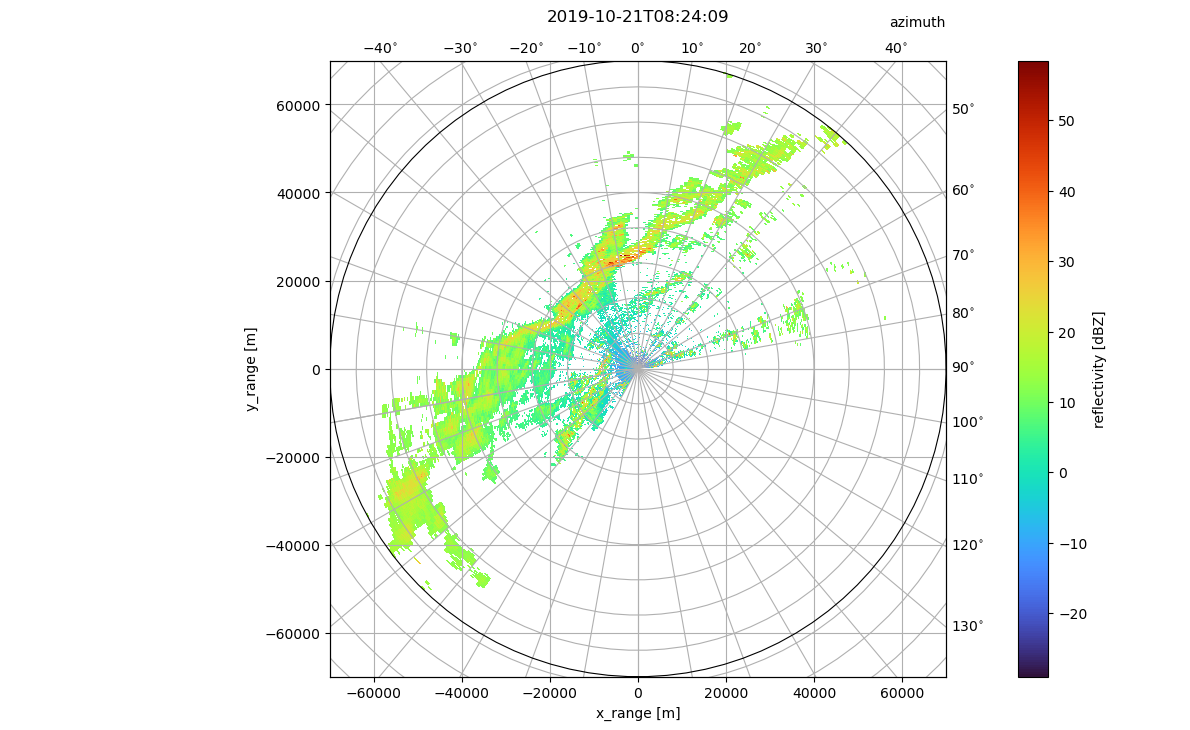

In [21]:
fig = plt.figure(figsize=(14, 8))

pm = swp.DBZH.pipe(wrl.georef.georeference_dataset).wradlib.plot(
    proj="cg", fig=fig, cmap="turbo"
)

ax = plt.gca()

# apply eye-candy
caax = ax.parasites[0]
paax = ax.parasites[1]
ax.parasites[1].set_aspect("equal")
t = plt.title(f"{vol[0].time.values.astype('M8[s]')}", y=1.05)
cbar = plt.colorbar(pm, pad=0.075, ax=paax)
caax.set_xlabel("x_range [m]")
caax.set_ylabel("y_range [m]")
plt.text(1.0, 1.05, "azimuth", transform=caax.transAxes, va="bottom", ha="right")
cbar.set_label("reflectivity [dBZ]")

### Making a vertical cut of the volume (fake RHI)
#### New function cross_section_ppi since Wradlib 1.18. Similar to Py-ART's cross_section_ppi

The volume elements need to have time dimension even if it is a single timestep (because how utility functions in wradlib work), then we add time dimension first:

In [22]:
# we create an empty volume
vol2 = wrl.io.xarray.RadarVolume()

# we take each element in vol, add time dimension and append it to vol2
for vv in vol:
    vol2.append(vv.expand_dims("time"))

We apply the function to extract a cross section of the volume at a certain azimuth:

In [23]:
# Extract a single azimuth
azimuth = 260.5
rec_rhi = wrl.util.cross_section_ppi(vol2, azimuth)


Plot the result:

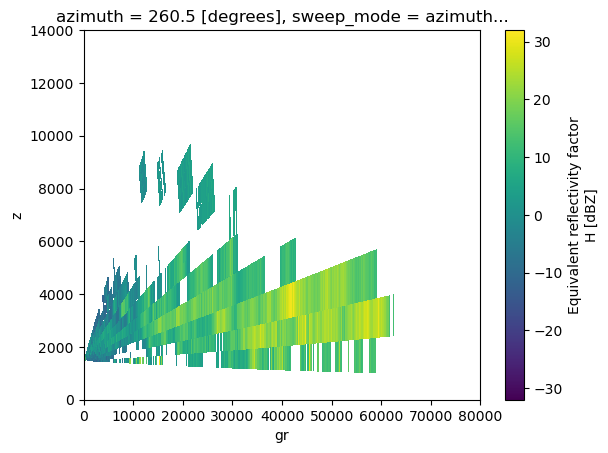

In [24]:
rec_rhi.DBZH[0].plot(cmap='viridis', x="gr", y="z", ylim=(0,14000), xlim=(0, 80000))


We can add the option real_beams=True, which will generate "fake" empty beams to produce a dataset that, when plotted, represents the real beam width (be default beam width = 1 degree)


In [25]:
bw = 1 # beam width in degrees, this will depend on the radar
rec_rhi = wrl.util.cross_section_ppi(vol2, azimuth, real_beams=True, bw=bw)


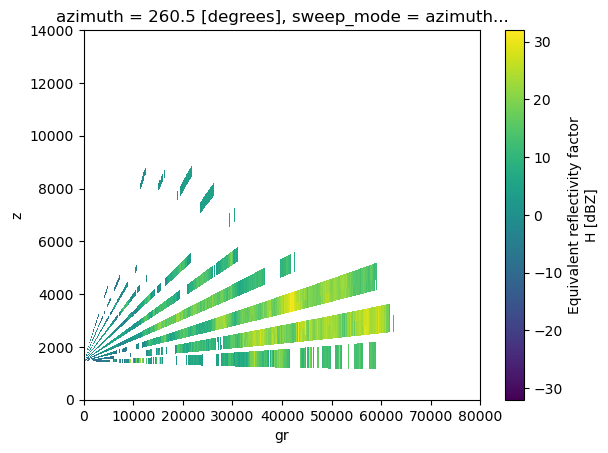

In [26]:
# Plot result
rec_rhi.DBZH[0].plot(cmap='viridis', x="gr", y="z", ylim=(0,14000), xlim=(0, 80000))


We can extract two opposing azimuths and plot both left and right of the radar:


In [27]:
azimuths = [azimuth, azimuth-180]

rec_rhi_2 =  wrl.util.cross_section_ppi(vol2, azimuths)

rec_rhi0 = rec_rhi_2.isel(azimuth=0)
rec_rhi180 = rec_rhi_2.isel(azimuth=1)

# we have to invert the gr and range coordinates in one of them so that they are opposite to each other
rec_rhi180.coords["gr"] = rec_rhi180.coords["gr"]*-1
rec_rhi180.coords["range"] = rec_rhi180.coords["range"]*-1


/tmp/ipykernel_15797/1949423905.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(rec_rhi0.gr, rec_rhi0.z, rec_rhi0.DBZH[0], cmap='viridis')
/tmp/ipykernel_15797/1949423905.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(rec_rhi180.gr, rec_rhi180.z, rec_rhi180.DBZH[0], cmap='viridis')


(0.0, 10000.0)

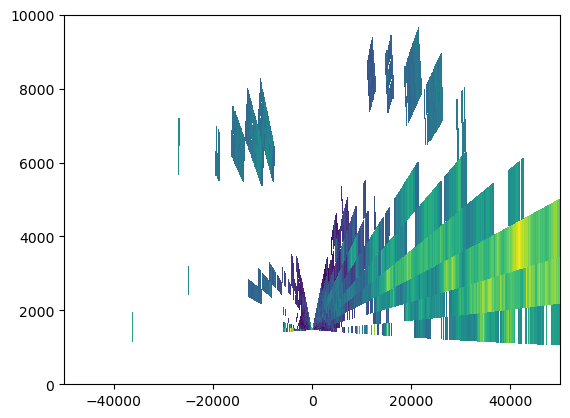

In [28]:
# PLot
plt.pcolormesh(rec_rhi0.gr, rec_rhi0.z, rec_rhi0.DBZH[0], cmap='viridis')
plt.pcolormesh(rec_rhi180.gr, rec_rhi180.z, rec_rhi180.DBZH[0], cmap='viridis')
plt.xlim(-50000, 50000)
plt.ylim(0, 10000)


We can make an arbitrary cut by providing two points through where a line of values will be extracted

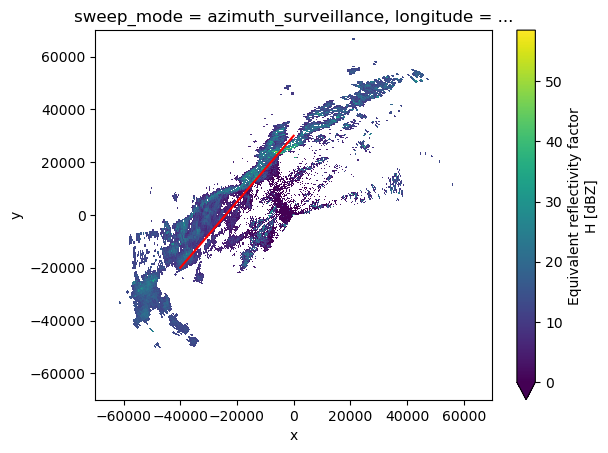

In [29]:
# Choose two points (in meters in the coordinates x,y of the georeferenced data)
vol0 = wrl.georef.georeference_dataset(vol2[0])

p1 = (-40000, -20000)
p2 = (0, 30000)

# Plot the chosen line over a PPI
vol0.DBZH[0].plot(x="x", y="y", vmin=0, cmap="viridis")
plt.plot([p1[0], p2[0]], [p1[1], p2[1]], c="red")


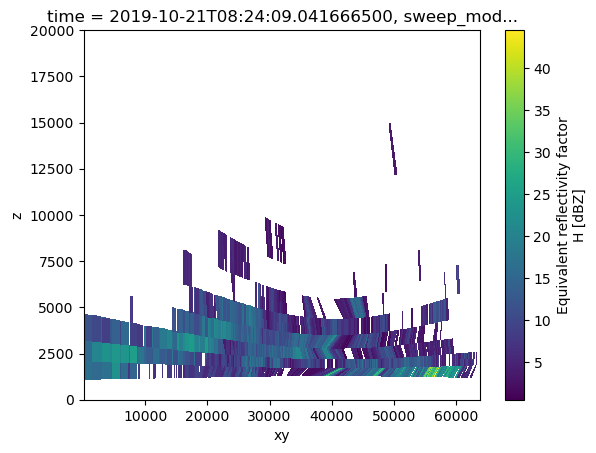

In [30]:
# Extract cross section and plot result
rec_rhi = wrl.util.cross_section_ppi(vol2, (p1,p2))

# We have to use the new coordinate "xy" (meters along the line from p1 to p2) for plotting
rec_rhi.DBZH[0].plot(cmap="viridis", x="xy", y="z", ylim=(0,20000))


## ODIM_H5 format export and import
### Export to ODIM_H5

To save the file, we need to pass a "source" parameter compliant with the format standard:

http://eumetnet.eu/wp-content/uploads/2017/01/OPERA_hdf_description_2014.pdf (page 11)

for example, source="RAD:xxxx" 

In [31]:
# I don't know the exact code for this radar so let's just put zeros
vol.to_odim("test_odim_vol.h5", source="RAD:0000")

### Import from ODIM_H5

In [32]:
vol2 = wrl.io.open_odim_dataset("test_odim_vol.h5")
display(vol2)

/home/jgiles/mambaforge/envs/wradlib4/lib/python3.11/site-packages/wradlib/io/hdf.py:92: FutureWarning: `open_odim_dataset` functionality has been moved to `xradar`-package and will be removed in 2.0. Use `open_odim_datatree` from `xradar`-package.
  return open_radar_dataset(filename_or_obj, engine=OdimBackendEntrypoint, **kwargs)


<wradlib.RadarVolume>
Dimension(s): (sweep: 10)
Elevation(s): (0.0, 1.3, 2.9, 4.9, 7.3, 10.2, 13.8, 18.2, 23.5, 30.0)

In [33]:
display(vol2[0])

<xarray.Dataset>
Dimensions:            (azimuth: 360, range: 1400)
Coordinates:
  * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    elevation          (azimuth) float32 ...
    rtime              (azimuth) datetime64[ns] ...
  * range              (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
    sweep_mode         <U20 ...
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
    time               datetime64[ns] 2019-10-21T08:24:09.041666816
Data variables:
    DBZH               (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    PHIDP              (azimuth, range) float32 ...
    RHOHV              (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    WRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 0.0
Attributes:
    fixed_angle:  0.0

## Import with xarray backends
### This is now the recommended way of opening files!

We can facilitate the xarray backend's which xradar (previosly wradlib) provides for the different readers. The xarray backends are capable of loading data into a single Dataset.

### Open single files

The simplest case can only open one file

In [34]:
ds = xr.open_dataset("test_odim_vol.h5", engine="odim")
display(ds)

<xarray.Dataset>
Dimensions:            (azimuth: 360, range: 1400)
Coordinates:
  * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    elevation          (azimuth) float32 ...
    time               (azimuth) datetime64[ns] ...
  * range              (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
Data variables:
    DBZH               (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    PHIDP              (azimuth, range) float32 ...
    RHOHV              (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    WRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    sweep_mode         <U20 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...

### Open multiple files

Here we need to specify the group, which in case of rainbow files is given by the group number. 

In [35]:
ds = xr.open_mfdataset(fglob, engine="rainbow", group="sweep_0", combine="by_coords")
display(ds)

<xarray.Dataset>
Dimensions:            (azimuth: 360, range: 1400)
Coordinates:
  * azimuth            (azimuth) float64 0.4999 1.505 2.505 ... 358.5 359.5
    elevation          (azimuth) float64 dask.array<chunksize=(360,), meta=np.ndarray>
  * range              (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
    time               (azimuth) datetime64[ns] dask.array<chunksize=(360,), meta=np.ndarray>
    longitude          float64 6.954
    latitude           float64 46.77
    altitude           float64 735.0
Data variables:
    DBZH               (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    sweep_mode         <U20 'azimuth_surveillance'
    sweep_number       int64 0
    prt_mode           <U7 'not_set'
    follow_mode        <U7 'not_set'
    sweep_fixed_angle  float64 0.0
    KDP                (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    PHIDP              (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    RHOHV              (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    VRADH              (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    WRADH              (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    ZDR                (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>

If we want to have everything in a radar volume, we have to open all sweeps and build it manually

In [36]:
# we create an empty volume
vol = wrl.io.xarray.RadarVolume()

# we take each element in vol, add time dimension and append it to vol2
for n in np.arange(10):
    vol.append(xr.open_mfdataset(fglob, engine="rainbow", group="sweep_"+str(n), combine="by_coords"))

In [37]:
vol

<wradlib.RadarVolume>
Dimension(s): (sweep: 10)
Elevation(s): (0.0, 1.3, 2.9, 4.9, 7.3, 10.2, 13.8, 18.2, 23.5, 30.0)

## Gridding and Export to GIS formats

- get coordinates from source Dataset with given projection
- calculate target coordinates
- grid using wradlib interpolator
- export to single band geotiff
- use GDAL CLI tools to convert to grayscaled/paletted PNG

In [38]:
def get_target_grid(ds, nb_pixels):
    xgrid = np.linspace(ds.x.min(), ds.x.max(), nb_pixels, dtype=np.float32)
    ygrid = np.linspace(ds.y.min(), ds.y.max(), nb_pixels, dtype=np.float32)
    grid_xy_raw = np.meshgrid(xgrid, ygrid)
    grid_xy_grid = np.dstack((grid_xy_raw[0], grid_xy_raw[1]))
    return xgrid, ygrid, grid_xy_grid


def get_target_coordinates(grid):
    grid_xy = np.stack((grid[..., 0].ravel(), grid[..., 1].ravel()), axis=-1)
    return grid_xy


def get_source_coordinates(ds):
    xy = np.stack((ds.x.values.ravel(), ds.y.values.ravel()), axis=-1)
    return xy


def coordinates(da, proj, res=100):
    # georeference single sweep
    da = da.pipe(wrl.georef.georeference_dataset, proj=proj)
    # get source coordinates
    src = get_source_coordinates(da)
    # create target grid
    xgrid, ygrid, trg = get_target_grid(da, res)
    return src, trg


def moment_to_gdal(da, trg_grid, driver, ext, path="", proj=None):
    # use wgs84 pseudo mercator if no projection is given
    if proj is None:
        proj = wrl.georef.epsg_to_osr(3857)
    t = da.time[0].values.astype("M8[s]").astype("O")
    outfilename = f"gridded_{da.name}_{t:%Y%m%d}_{t:%H%M%S}"
    outfilename = os.path.join(path, outfilename)
    f = pathlib.Path(outfilename)
    f.unlink(missing_ok=True)
    res = ip_near(da.values.ravel(), maxdist=1000).reshape(
        (len(trg_grid[0]), len(trg_grid[1]))
    )
    data, xy = wrl.georef.set_raster_origin(res, trg_grid, "upper")
    ds = wrl.georef.create_raster_dataset(data, xy, projection=proj)
    wrl.io.write_raster_dataset(outfilename + ext, ds, driver)

### Coordinates

In [39]:
%%time
epsg_code = 2056
proj = wrl.georef.epsg_to_osr(epsg_code)
src, trg = coordinates(ds, proj, res=1400)

CPU times: user 590 ms, sys: 46.6 ms, total: 637 ms
Wall time: 641 ms


### Interpolator

In [40]:
%%time
ip_near = wrl.ipol.Nearest(src, trg.reshape(-1, trg.shape[-1]), remove_missing=7)

CPU times: user 2.09 s, sys: 381 ms, total: 2.47 s
Wall time: 2.48 s


### Gridding and Export

In [41]:
%%time
moment_to_gdal(ds.DBZH, trg, "GTiff", ".tif", proj=proj)

CPU times: user 326 ms, sys: 85.2 ms, total: 411 ms
Wall time: 421 ms


### GDAL info on created GeoTiff

In [42]:
!gdalinfo gridded_DBZH_20191021_082427.tif

Driver: GTiff/GeoTIFF
Files: gridded_DBZH_20191021_082427.tif
Size is 1400, 1400
Coordinate System is:
PROJCRS["CH1903+ / LV95",
    BASEGEOGCRS["CH1903+",
        DATUM["CH1903+",
            ELLIPSOID["Bessel 1841",6377397.155,299.1528128,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4150]],
    CONVERSION["Swiss Oblique Mercator 1995",
        METHOD["Hotine Oblique Mercator (variant B)",
            ID["EPSG",9815]],
        PARAMETER["Latitude of projection centre",46.9524055555556,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8811]],
        PARAMETER["Longitude of projection centre",7.43958333333333,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8812]],
        PARAMETER["Azimuth of initial line",90,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8813]],
        PARAMETER["Angle from Rectified to Skew

### Translate exported GeoTiff to grayscale PNG

In [43]:
!gdal_translate -of PNG -ot Byte -scale -30. 60. 0 255 gridded_DBZH_20191021_082427.tif grayscale.png

Input file size is 1400, 1400
Warning 1: for band 1, nodata value has been clamped to 0, the original value being out of range.
0...10...20...30...40...50...60...70...80...90...100 - done.


### Apply colortable to PNG

In [44]:
with open("colors.txt", "w") as f:
    f.write("0 blue\n")
    f.write("50 yellow\n")
    f.write("100 yellow\n")
    f.write("150 orange\n")
    f.write("200 red\n")
    f.write("250 white\n")

### Display exported PNG's

In [45]:
!gdaldem color-relief grayscale.png colors.txt paletted.png

0...10...20...30...40...50...60...70...80...90...100 - done.


<img src="grayscale.png" width=400 alt="grayscale png" align="left"></img>
<img src="paletted.png" width=400 alt="paletted png" align="left"></img>

### Import with Xarray, rasterio backend

/home/jgiles/mambaforge/envs/wradlib4/lib/python3.11/site-packages/pyproj/crs/_cf1x8.py:514: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


<xarray.Dataset>
Dimensions:      (band: 1, x: 1400, y: 1400)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.493e+06 2.493e+06 ... 2.633e+06 2.633e+06
  * y            (y) float64 1.25e+06 1.25e+06 1.25e+06 ... 1.11e+06 1.11e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

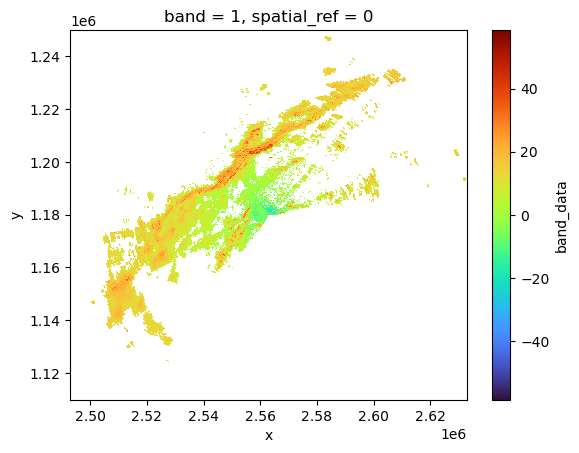

In [46]:
with xr.open_dataset("gridded_DBZH_20191021_082427.tif", engine="rasterio") as ds_grd:
    display(ds_grd)
    ds_grd.band_data.plot(cmap="turbo")

## xradar
### Import with xradar

We can use xradar to open the rainbow files, but only one at the time. Let's open the first one:

In [47]:
files = glob.glob(fglob)
vol_xd = xd.io.open_rainbow_datatree(files[0])

In [48]:
vol_xd

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 0
│       platform_type        <U5 'fixed'
│       instrument_type      <U5 'radar'
│       time_coverage_start  <U20 '2019-10-21T08:24:09Z'
│       time_coverage_end    <U20 '2019-10-21T08:29:33Z'
│       longitude            float64 6.954
│       altitude             float64 735.0
│       latitude             float64 46.77
│   Attributes:
│       Conventions:      None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
│       instrument_name:  None
├── DataTree('sweep_0')
│       Dimensions:            (azimuth: 360, range: 1400)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.4999 1.505 2.505 ... 358.5 359.5
│           elevation          (azimuth) float64 ...
│         * range              (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
│           time               (azimuth) datetime64[ns] 2019-10-21T08:24:27.875000 .....
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           KDP                (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_1')
│       Dimensions:            (azimuth: 360, range: 1400)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.4999 1.5 2.499 ... 357.5 358.5 359.5
│           elevation          (azimuth) float64 ...
│         * range              (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
│           time               (azimuth) datetime64[ns] 2019-10-21T08:24:57.208333500...
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           KDP                (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_2')
│       Dimensions:            (azimuth: 360, range: 1400)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.4999 1.502 2.499 ... 358.5 359.5
│           elevation          (azimuth) float64 ...
│         * range              (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
│           time               (azimuth) datetime64[ns] 2019-10-21T08:25:27.291666500...
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           KDP                (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_3')
│       Dimensions:            (azimuth: 360, range: 1400)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.4999 1.502 2.499 ... 358.5 359.5
│           elevation          (azimuth) float64 ...
│         * range              (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
│           time               (azimuth) datetime64[ns] 2019-10-21T08:25:57.541666500...
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           KDP                (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode          

In [49]:
vol_xd["sweep_9"]

DataTree('sweep_9', parent="root")
    Dimensions:            (azimuth: 360, range: 1400)
    Coordinates:
      * azimuth            (azimuth) float64 0.4999 1.502 2.497 ... 358.5 359.5
        elevation          (azimuth) float64 ...
      * range              (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
        time               (azimuth) datetime64[ns] 2019-10-21T08:29:27.541666499...
        longitude          float64 ...
        latitude           float64 ...
        altitude           float64 ...
    Data variables:
        KDP                (azimuth, range) float32 ...
        sweep_mode         <U20 ...
        sweep_number       int64 ...
        prt_mode           <U7 ...
        follow_mode        <U7 ...
        sweep_fixed_angle  float64 ...

We can transform it to an xarray Dataset like this:

In [50]:
vol_xd["sweep_9"].to_dataset()

<xarray.Dataset>
Dimensions:            (azimuth: 360, range: 1400)
Coordinates:
  * azimuth            (azimuth) float64 0.4999 1.502 2.497 ... 358.5 359.5
    elevation          (azimuth) float64 ...
  * range              (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
    time               (azimuth) datetime64[ns] 2019-10-21T08:29:27.541666499...
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
Data variables:
    KDP                (azimuth, range) float32 ...
    sweep_mode         <U20 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...

You can then open several files into datatrees, transform them to xarray Dataset and merge them into a single Dataset.

### Export to ODIM with xradar

In [51]:
xd.io.to_odim(vol_xd, "test_odim_vol_xd.h5", source="RAD")

### Open other formats

In [52]:
armor = "../../data/qc/uah-armor/cfrad.20080411_182230.747_to_20080411_182629.530_ARMOR_SUR.nc"

In [53]:
armor_swp = xr.open_dataset(armor, group="sweep_0",  engine="cfradial1")

In [54]:
armor_swp

<xarray.Dataset>
Dimensions:                    (time: 4319, range: 992, azimuth: 360)
Coordinates:
  * time                       (time) datetime64[ns] 2008-04-11T18:22:30.7469...
  * range                      (range) float32 1e+03 1.125e+03 ... 1.249e+05
  * azimuth                    (azimuth) float32 0.02747 1.052 ... 358.0 359.1
    elevation                  (azimuth) float32 ...
    latitude                   (time) float64 ...
    longitude                  (time) float64 ...
    altitude                   (time) float64 ...
Data variables: (12/47)
    sweep_number               float64 ...
    sweep_mode                 |S32 ...
    prt_mode                   |S32 ...
    follow_mode                |S32 ...
    sweep_fixed_angle          float32 ...
    ray_start_range            (azimuth) float32 ...
    ...                         ...
    PHIDP                      (azimuth, range) float32 ...
    RHOHV                      (azimuth, range) float32 ...
    WIDTH                      (azimuth, range) float32 ...
    VEL                        (azimuth, range) float32 ...
    REF                        (azimuth, range) float32 ...
    VR                         (azimuth, range) float32 ...

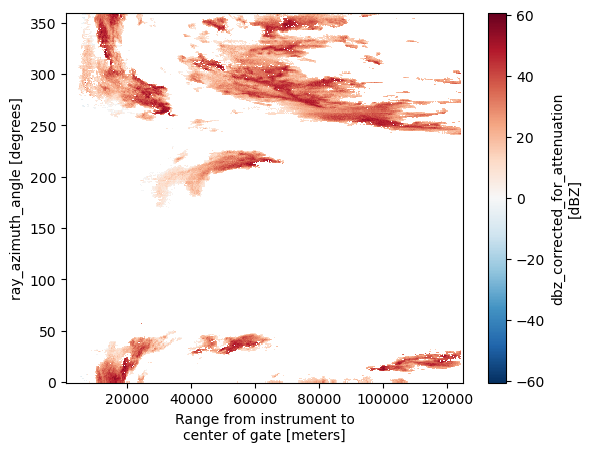

In [55]:
armor_swp["DBZ"].plot()

In [56]:
nexrad = "../../data/qc/nexrad/cfrad.20080411_181143.771_to_20080411_181635.745_KHTX_SUR.nc"

In [57]:
nexrad_swp = xr.open_dataset(nexrad,group="sweep_1", engine="cfradial1")

ValueError: Dimensions {'n_points'} do not exist. Expected one or more of Frozen({'azimuth': 360, 'range': 1840})

In [58]:
nexrad_swp = xr.open_dataset(nexrad, engine="cfradial1")

In [59]:
nexrad_swp

<xarray.Dataset>
Dimensions:              (frequency: 1, sweep: 14, time: 5040)
Coordinates:
  * frequency            (frequency) float32 2.755e+09
Dimensions without coordinates: sweep, time
Data variables: (12/13)
    volume_number        float64 ...
    platform_type        |S32 ...
    primary_axis         |S32 ...
    status_str           |S1 ...
    instrument_type      |S32 ...
    time_coverage_start  |S32 ...
    ...                   ...
    sweep_group_name     (sweep) <U10 ...
    sweep_fixed_angle    (sweep) float32 ...
    latitude             (time) float64 ...
    longitude            (time) float64 ...
    altitude             (time) float64 ...
    altitude_agl         (time) float64 ...
Attributes: (12/14)
    Conventions:         CF-1.7
    version:             CF-Radial-1.4
    title:               
    institution:         
    references:          
    source:              ARCHIVE
    ...                  ...
    instrument_name:     KHTX
    site_name:           
    scan_name:           
    scan_id:             0
    platform_is_mobile:  false
    ray_times_increase:  true

---

## Summary
We've just learned how to use $\omega radlib$'s xarray backends to make radar volume data available as xarray Datasets and DataArrays. Accessing, plotting and exporting data has been shown.

### What's next?
In the next notebook we dive into data quality processing.

## Resources and references

- [xarray](https://docs.xarray.dev)
- [dask](https://docs.dask.org)
- [matplotlib](https://matplotlib.org/stable/index.html)
- [matplotlib axisartist](https://matplotlib.org/stable/tutorials/toolkits/axisartist.html)
- [cartopy](https://scitools.org.uk/cartopy/docs/latest)
- [gdal](https://gdal.org/index.html)
- [wradlib xarray backends](https://docs.wradlib.org/en/stable/notebooks/fileio/wradlib_xarray_backends.html)
- [rioxarray](https://corteva.github.io/rioxarray/stable/)
- [wradlib scan strategy](https://docs.wradlib.org/en/stable/notebooks/visualisation/wradlib_plot_scan_strategy.html)
- [Leonardo - Rainbow5](https://electronics.leonardo.com/en/products/rainbow-5-application-software)
- [OPERA ODIM_H5](https://www.eumetnet.eu/activities/observations-programme/current-activities/opera/)
- [WMO JET-OWR](https://community.wmo.int/governance/commission-membership/commission-observation-infrastructure-and-information-systems-infcom/commission-infrastructure-officers/infcom-management-group/standing-committee-measurements-instrumentation-and-traceability-sc-mint/joint-expert-team)